 <p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px"></p>


# Support vector machine to predict stock prices

</br>

In this chapter, we will explain how the SVM works theorically. Then, we will apply this algorithm to predict stock price and create a trading strategy

### Summary
* How a SVM works theorically
* Predict stock price using a SVM
* Create trading strategy 

</br>

💰Join our community: https://discord.gg/wXjNPAc5BH

📚Read our book: https://www.amazon.com/gp/product/B09HG18CYL 

🖥️Quantreo's YouTube channel: https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw

In [ ]:
! pip install yfinance
! pip install ta

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import ta

In [ ]:
import matplotlib as mpl
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

# How a SVM algorithm works theorically
Look the video and the attached PDF.

# Predict stock prices using a SVR (SVM regressor)



### Import the data from Yahoo (esiest choice)
**IMPORTANT**: You can import the data from Yahoo or from MT5. But you need to have a Windows device to use MT5. To avoid this problem, you can see the video introduction video of the chapter MetaTrader 5 Live Trading! 


In [ ]:
# Import the data
df = yf.download("GOOG")[["Open", "High", "Low", "Adj Close", "Volume"]]

df.columns = ["open", "high", "low", "close", "volume"]

[*********************100%***********************]  1 of 1 completed


### Features Engineering


In [ ]:
def feature_engineering(df):
  """ Create new variables"""
  
  # We copy the dataframe to avoid interferences in the data
  df_copy = df.dropna().copy()
  
  # Create the returns
  df_copy["returns"] = df_copy["close"].pct_change(1)

  # Create the SMAs
  df_indicators = ta.add_all_ta_features(
  df, open="open", high="high", low="low", close="close", volume="volume", fillna=True).shift(1)
  
  dfc = pd.concat((df_indicators, df_copy), axis=1)

  return dfc.dropna()

In [ ]:
dfc = feature_engineering(df)
dfc

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,...,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,returns
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-08-20,49.813290,51.835709,47.800831,49.982655,44871361.0,3.656206e+06,4.487136e+07,0.081482,0.000000e+00,50.000000,0.000000,0.000000,-4.140941e+07,1000.000000,49.873065,0.000000,49.982655,49.982655,49.982655,0.000000,0.000000,0.0,0.0,49.873065,53.907942,45.838187,16.180589,0.513580,0.0,0.0,47.800831,51.835709,49.818270,8.072556,0.540741,0.000000,0.000000,0.000000,0.000000,49.982655,...,0.015514,2.009459,66.666667,596.496323,-919.860301,-921.390886,1.530584,51.068583,51.068583,51.068583,51.068583,642.061120,631.172755,8.0,4.0,4.0,-1.000000,-1.000000,0.0,0.0,0.000000,100.000000,0.000000,0.000000,0.000000,100.000000,47.327752,94.131072,74.102585,-5.868928,0.000000,51.709669,0.000000,-4.044858,-0.808972,-3.235887,7.942987,7.643300,7.942987,0.079430
2004-08-23,50.316402,54.336334,50.062355,53.952770,22942874.0,2.248111e+07,6.781424e+07,0.331510,9.108586e+07,100.000000,44.356538,44.356538,-3.959039e+07,1079.429868,50.857830,0.000000,51.967712,55.937828,47.997597,15.279163,0.750000,0.0,0.0,51.328442,55.482871,47.174014,16.187627,0.815847,0.0,0.0,47.800831,54.336334,51.068583,12.576084,0.941311,0.000000,0.316704,0.063341,0.253364,51.967712,...,0.042838,2.941683,92.892055,595.653649,-918.560809,-920.447527,1.886718,52.164474,52.164474,52.164474,52.164474,642.061120,631.172755,12.0,4.0,8.0,47.800831,-1.000000,1.0,0.0,0.000000,100.000000,0.000000,0.000000,0.000000,100.000000,41.163075,76.712317,74.972495,-23.287683,0.000000,52.919278,0.000000,-8.373489,-2.321875,-6.051614,1.006371,1.001341,9.029294,0.010064
2004-08-24,55.168217,56.528118,54.321388,54.495735,18342897.0,7.036644e+06,8.615713e+07,0.081672,7.949639e+07,100.000000,38.803061,41.579799,2.006947e+06,1090.292935,51.764201,0.000000,52.810387,56.833902,48.786871,15.237592,0.709437,0.0,0.0,52.590655,56.095851,49.085459,13.330108,0.771751,0.0,0.0,47.800831,56.528118,52.164474,16.525702,0.767123,0.000000,0.604539,0.171580,0.432958,52.810387,...,0.067978,3.898774,19.269197,595.796446,-918.781017,-920.030899,1.249882,52.164474,52.164474,52.164474,52.164474,642.061120,631.172755,12.0,4.0,8.0,48.149922,-1.000000,0.0,0.0,0.000000,63.509651,0.000000,0.000000,0.000000,98.723193,34.487343,50.856191,73.899860,-49.143809,0.000000,52.633457,0.000000,-12.703524,-4.398205,-8.305319,-4.140761,-4.228934,4.514651,-0.041408
2004-08-25,55.412300,55.591629,51.591621,52.239197,15319808.0,-3.322809e+06,7.083732e+07,-0.032744,6.320123e+07,73.185672,-47.863040,11.765519,-4.497591e+05,1045.146506,51.972026,0.000000,52.667589,56.186993,49.148186,13.364590,0.439138,0.0,0.0,52.728195,56.357094,49.099297,13.764547,0.432624,0.0,0.0,47.800831,56.528118,52.164474,16.570508,0.508562,0.000000,0.643152,0.265895,0.377257,52.667589,...,0.092612,4.791987,2.510662,595.769547,-918.739536,-919.772627,1.033091,5

### Create different sets of data

In [ ]:
# Percentage train set
split = int(0.80*len(dfc))

# Train set creation
X_train = dfc.iloc[:split,6:dfc.shape[1]-1]
y_train = dfc[["returns"]].iloc[:split]


# Test set creation
X_test = dfc.iloc[split:,6:dfc.shape[1]-1]
y_test = dfc[["returns"]].iloc[split:]

### Standardisation

In [ ]:
# STANDARDISATION
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

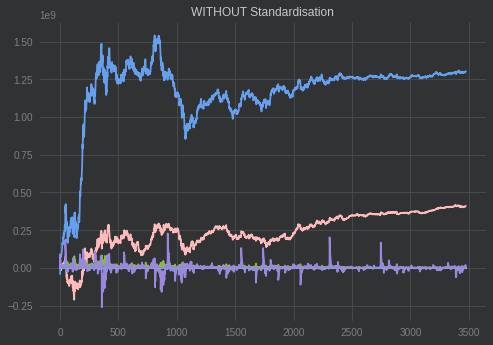

In [ ]:
plt.plot(X_train.values[:,0:15])
plt.title("WITHOUT Standardisation")
plt.show()

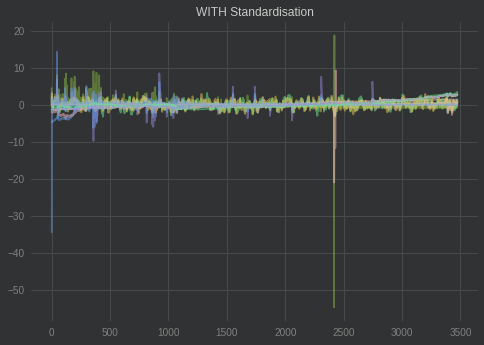

In [ ]:
plt.plot(X_train_sc[:,0:15], alpha=0.5)
plt.title("WITH Standardisation")
plt.show()

### PCA

Principal Component Analysis (PCA) is a statistical procedure that uses an orthogonal transformation that converts a set of correlated variables to a set of uncorrelated variables. PCA is the most widely used tool in exploratory data analysis and in machine learning for predictive models. Moreover, PCA is an unsupervised statistical technique used to examine the interrelations among a set of variables. (source: GeeksforGeeks)

In [ ]:
# DIMENSION REDUCTION
from sklearn.decomposition import PCA
pca = PCA(n_components=6)

X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [ ]:
print(f"Without PCA: {np.shape(X_train)} \nWith PCA: {np.shape(X_train_pca)}")

Without PCA: (3475, 94) 
With PCA: (3475, 6)


### SVR training

scikit-learn documentation: https://scikit-learn.org/stable/

In [ ]:
# Import the class
from sklearn.svm import SVR

# Initialize the class
reg = SVR()

# Fit the model
reg.fit(X_train_pca, y_train)

SVR()

### SVR variation predictions

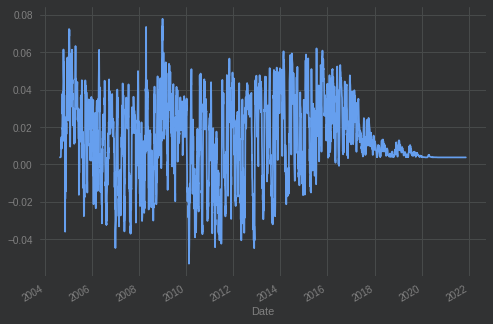

In [ ]:
# Create predictions for the whole dataset
X = np.concatenate((X_train_pca, X_test_pca), axis=0)

dfc["prediction"] = reg.predict(X)

# We verify that the algorithm doesn't predict only way (positive or negative)
dfc["prediction"].plot()

### Backtest function

In [ ]:
def BackTest(serie, annualiazed_scalar=252):
  def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    return drawdown

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  # Concat the returns and the sp500
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Compute the drawdown
  drawdown = drawdown_function(serie)*100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()


  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

### BACKTEST

[*********************100%***********************]  1 of 1 completed


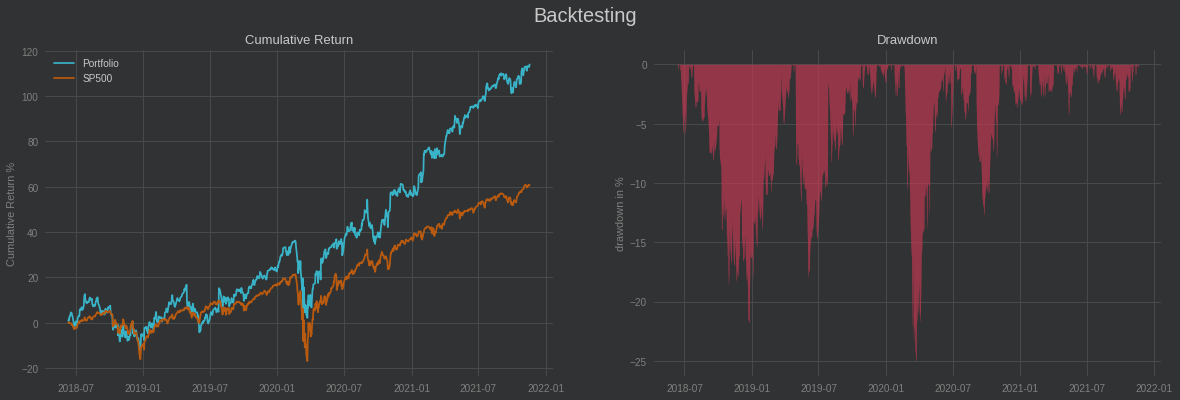

Sortino: 1.472
Beta: 1.047
Alpha: -1.542 %
MaxDrawdown: 25.001 %


In [ ]:
# Compute the position
dfc["position"] = np.sign(dfc["prediction"])

# Compute the returns
dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)

dfc["return"] = dfc["strategy"]
BackTest(dfc["return"].iloc[split:])

# APPLICATION

### FUNCTION

In [ ]:
def svm_reg_trading(symbol):

  def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Create the SMAs
    df_indicators = ta.add_all_ta_features(
    df, open="open", high="high", low="low", close="close", volume="volume", fillna=True).shift(1)
    
    dfc = pd.concat((df_indicators, df_copy), axis=1)

    return dfc.dropna()
  

  # Import the data
  df = yf.download(symbol)[["Open", "High", "Low", "Adj Close", "Volume"]]

  df.columns = ["open", "high", "low", "close", "volume"]

  dfc = feature_engineering(df)

  # Percentage train set
  split = int(0.80*len(dfc))

  # Train set creation
  X_train = dfc.iloc[:split,6:dfc.shape[1]-1]
  y_train = dfc[["returns"]].iloc[:split]


  # Test set creation
  X_test = dfc.iloc[split:,6:dfc.shape[1]-1]
  y_test = dfc[["returns"]].iloc[split:]


  # What you need to remind about this chapter
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()

  X_train_sc = sc.fit_transform(X_train)
  X_test_sc = sc.transform(X_test)


  from sklearn.decomposition import PCA
  pca = PCA(n_components=6)
  X_train_pca = pca.fit_transform(X_train_sc)
  X_test_pca = pca.transform(X_test_sc)

  # Import the class
  from sklearn.svm import SVR

  # Initialize the class
  reg = SVR()

  # Fit the model
  reg.fit(X_train_pca, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train_pca, X_test_pca), axis=0)

  dfc["prediction"] = reg.predict(X)

  # Compute the position
  dfc["position"] = np.sign(dfc["prediction"])

  # Compute the returns
  dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)

  dfc["return"] = dfc["strategy"]
  BackTest(dfc["return"].iloc[split:])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


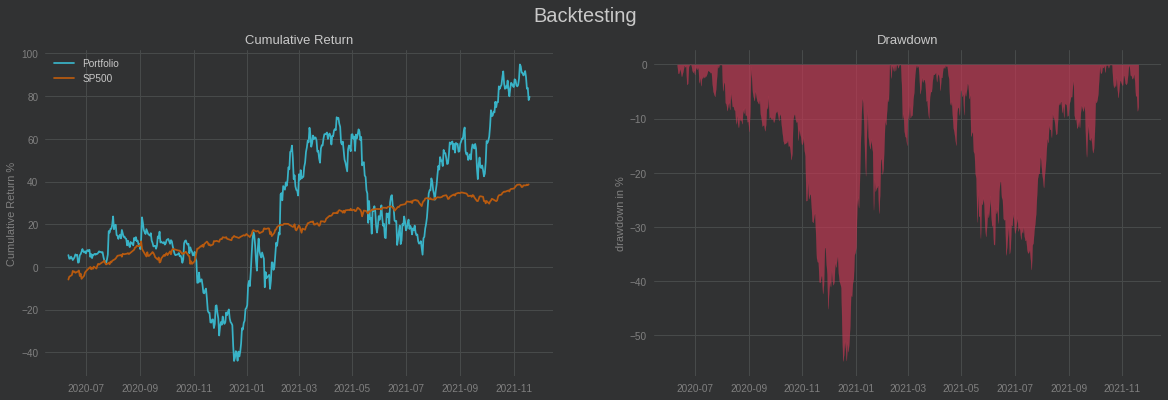

Sortino: 0.957
Beta: 0.308
Alpha: 26.5 %
MaxDrawdown: 54.723 %


In [ ]:
svm_reg_trading("BTC-USD")